In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
import pgmpy
from pgmpy.estimators import ConstraintBasedEstimator
from sklearn.preprocessing import LabelEncoder 
import warnings
import networkx as nx
from IPython.display import SVG, display
from PIL import Image
from pgmpy.models import BayesianModel
from pgmpy.estimators import BicScore
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'C:\Users\Leniu\Downloads\train.csv',sep=',')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## usuwanie niepotrzebnych danych i one-hot encoding (zamiana np. kobieta/męszczyzna na 0/1)

In [3]:

df['Age'] = df['Age'].replace('Nan',np.nan)
df["Age"] = df["Age"].fillna(df["Age"].mean())
df = df.drop(['PassengerId','Name','Cabin','Ticket'],axis=1)
df['Sex'] = LabelEncoder().fit_transform(y=df['Sex'])
df['Embarked'] = LabelEncoder().fit_transform(y=df['Embarked'])

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


## macierz koleracji

In [4]:
corr_matrix = df.corr()
corr_matrix

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,-0.543351,-0.069809,-0.035322,0.081629,0.257307,-0.163517
Pclass,-0.338481,1.000000,0.131900,-0.331339,0.083081,0.018443,-0.549500,0.157112
Sex,-0.543351,0.131900,1.000000,0.084153,-0.114631,-0.245489,-0.182333,0.104057
Age,-0.069809,-0.331339,0.084153,1.000000,-0.232625,-0.179191,0.091566,-0.022239
SibSp,-0.035322,0.083081,-0.114631,-0.232625,1.000000,0.414838,0.159651,0.066654
Parch,0.081629,0.018443,-0.245489,-0.179191,0.414838,1.000000,0.216225,0.038322
Fare,0.257307,-0.549500,-0.182333,0.091566,0.159651,0.216225,1.000000,-0.221226
Embarked,-0.163517,0.157112,0.104057,-0.022239,0.066654,0.038322,-0.221226,1.000000


<AxesSubplot:>

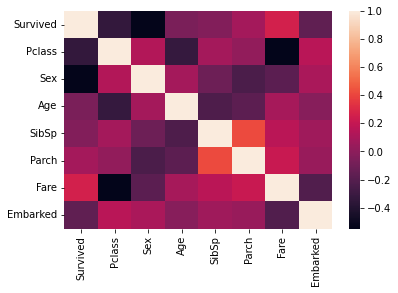

In [5]:
sns.heatmap(corr_matrix)

In [6]:
pcorr_matrix = df.pcorr().round(3)
pcorr_matrix

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000,-0.278,-0.521,-0.179,-0.106,-0.032,0.030,-0.069
Pclass,-0.278,1.000,-0.063,-0.334,0.067,0.069,-0.511,-0.001
Sex,-0.521,-0.063,1.000,-0.020,-0.063,-0.187,-0.023,0.036
Age,-0.179,-0.334,-0.020,1.000,-0.167,-0.081,-0.027,0.018
SibSp,-0.106,0.067,-0.063,-0.167,1.000,0.333,0.158,0.071
Parch,-0.032,0.069,-0.187,-0.081,0.333,1.000,0.180,0.068
Fare,0.030,-0.511,-0.023,-0.027,0.158,0.180,1.000,-0.180
Embarked,-0.069,-0.001,0.036,0.018,0.071,0.068,-0.180,1.000


In [7]:
pcorr_matrix = df.pcorr().round(3)
pcorr_matrix

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000,-0.278,-0.521,-0.179,-0.106,-0.032,0.030,-0.069
Pclass,-0.278,1.000,-0.063,-0.334,0.067,0.069,-0.511,-0.001
Sex,-0.521,-0.063,1.000,-0.020,-0.063,-0.187,-0.023,0.036
Age,-0.179,-0.334,-0.020,1.000,-0.167,-0.081,-0.027,0.018
SibSp,-0.106,0.067,-0.063,-0.167,1.000,0.333,0.158,0.071
Parch,-0.032,0.069,-0.187,-0.081,0.333,1.000,0.180,0.068
Fare,0.030,-0.511,-0.023,-0.027,0.158,0.180,1.000,-0.180
Embarked,-0.069,-0.001,0.036,0.018,0.071,0.068,-0.180,1.000


<AxesSubplot:>

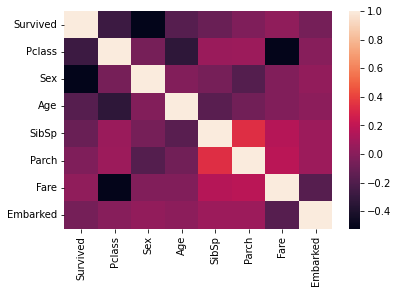

In [8]:
sns.heatmap(pcorr_matrix)

### zmiana wartości na przedziły

In [9]:
df["Age"] = pd.cut(df["Age"],3)
df["Fare"] =pd.cut(df["Fare"],3)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,"(0.34, 26.947]",1,0,"(-0.512, 170.776]",2
1,1,1,0,"(26.947, 53.473]",1,0,"(-0.512, 170.776]",0
2,1,3,0,"(0.34, 26.947]",0,0,"(-0.512, 170.776]",2
3,1,1,0,"(26.947, 53.473]",1,0,"(-0.512, 170.776]",2
4,0,3,1,"(26.947, 53.473]",0,0,"(-0.512, 170.776]",2


### konstrukcja sieci bayesa

In [17]:
est = ConstraintBasedEstimator(df)

#estymacja połączeń
skel,seperating_sets = est.estimate_skeleton(significance_level = 0.01)
pdag = est.skeleton_to_pdag(skel,seperating_sets)
model = est.pdag_to_dag(pdag)


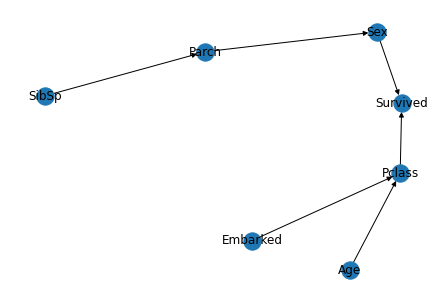

In [20]:
G = nx.DiGraph()
G.add_nodes_from(["Survived","Age","Pclass","Sex","SibSp","Parch","Fare","Embarked"])
G.add_edges_from(model.edges())
G.add_edges_from([("Sex","Survived"),("Pclass","Survived"),("SibSp","Parch")])
G.remove_edge("Parch","SibSp")
G.remove_node("Fare")
nx.draw(G,with_labels=True)

In [23]:
model = BayesianModel(G.edges)  

In [24]:
model.fit(df)
cpds = model.get_cpds()
for cpd in cpds:
    print(cpd, '\n\n')

+-----------------------+-----------+
| Age((0.34, 26.947])   | 0.358025  |
+-----------------------+-----------+
| Age((26.947, 53.473]) | 0.585859  |
+-----------------------+-----------+
| Age((53.473, 80.0])   | 0.0561167 |
+-----------------------+-----------+ 


+-------------+------------+
| Embarked(0) | 0.188552   |
+-------------+------------+
| Embarked(1) | 0.0864198  |
+-------------+------------+
| Embarked(2) | 0.722783   |
+-------------+------------+
| Embarked(3) | 0.00224467 |
+-------------+------------+ 


+----------+----------------------+----------------------+---------------------+----------+----------+----------+----------+
| SibSp    | SibSp(0)             | SibSp(1)             | SibSp(2)            | SibSp(3) | SibSp(4) | SibSp(5) | SibSp(8) |
+----------+----------------------+----------------------+---------------------+----------+----------+----------+----------+
| Parch(0) | 0.8832236842105263   | 0.5885167464114832   | 0.5714285714285714  | 0.125    | 